In [177]:
import os
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
import warnings
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.metrics import r2_score
from torch import nn
from torch.utils.data import DataLoader
from time import time
from IPython.core.display_functions import clear_output

In [178]:
device = "cpu"
convert = lambda x: x if x >= 150 else 0
convert = np.vectorize(convert)

In [179]:
warnings.filterwarnings("ignore")

In [180]:
if not os.path.isdir("raw_data"):
    os.chdir("../")

In [181]:
data = pd.read_csv("raw_data/db.csv", sep=";")

In [182]:
for i in dict(data.dtypes).items():
    if i[0] == "Дата":
        continue
    if i[1] == np.dtype('O'):
        data[i[0]] = data[i[0]].apply(lambda x: float(".".join(x.split(","))))

In [183]:
data.dtypes

Дата                                                       object
Выработка электроэнергии ТА гр.130                        float64
Отпуск тепла из ТО ТА гр.130                                int64
Удельный расход условного топлива на отпуск э/э гр.130    float64
Выработка электроэнергии ТА гр.90                         float64
Удельный расход тепла на выработку э/э ТА гр.130          float64
Удельный расход тепла на выработку э/э ТА гр.90           float64
Удельный расход условного топлива на отпуск э/э гр.90     float64
Расход пара в конденсатор ТА №3                           float64
Расход пара в конденсатор ТА №4                           float64
Расход пара в конденсатор ТА №5                           float64
Расход пара в конденсатор ТА №6                           float64
Расход пара в конденсатор ТА №7                           float64
Расход пара в конденсатор ТА №8                           float64
Расход свежего пара ТА №3                                   int64
Расход све

In [184]:
date = np.array([[0, 0, 0]], dtype=int)
for i in data["Дата"]:
    date = np.vstack([date, i.split("/")])

In [185]:
date = date[1:]

In [186]:
data["months"] = date[:, 0]
data.months = data.months.apply(int)

In [187]:
data["day"] = date[:, 1]
data.day = data.day.apply(int)

In [188]:
data["years"] = date[:, 2]
data.years = data.years.apply(int)

In [189]:
data = data.drop(["Дата"], axis=1)

In [190]:
fuel_columns = [
    "Удельный расход условного топлива на отпуск э/э гр.130",
    "Удельный расход условного топлива на отпуск э/э гр.90",
    "Расход топлива в условном исчислении КА №10",
    "Расход топлива в условном исчислении КА №11",
    "Расход топлива в условном исчислении КА №12",
    "Расход топлива в условном исчислении КА №5",
    "Расход топлива в условном исчислении КА №6",
    "Расход топлива в условном исчислении КА №7",
    "Расход топлива в условном исчислении КА №8",
    "Расход топлива в условном исчислении КА №9"
]

In [191]:
target = next(iter(fuel_columns))

In [192]:
def get_columns_without_tagrets(_target: str):
    return list(set(fuel_columns) - {_target})

In [193]:
X = data.drop(get_columns_without_tagrets(target), axis=1)

In [194]:
y = data[target]

In [195]:
input_shape = X.shape[1]

In [223]:
class SimpleNN(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_shape, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [224]:
def predict(model, prediction_data):
    model.eval()
    if isinstance(prediction_data, list):
        Y_pred = [model(X_batch.double()) for X_batch in prediction_data]
    else:
        Y_pred = [model(X_batch) for X_batch, _ in prediction_data]
    return Y_pred

In [301]:
def score_model(model, metric, prediction_data):
    model.eval()
    scores = 0
    for X_batch, Y_label in prediction_data:
        Y_pred = model(X_batch)
        scores += metric(
            Y_pred.detach().numpy(), Y_label.detach().numpy()
        ).mean().item()

    return scores / len(prediction_data)

In [253]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scoring=r2_score):
    loses = []
    scores = {
        "train": [],
        "val": []
    }
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()

            avg_loss += loss / len(data_tr)
        # scheduler.step(loss)
        toc = time()

        model.eval()

        scores["val"].append(
            score_model(model, scoring, data_val)
        )
        scores["train"].append(
            score_model(model, scoring, data_tr)
        )
        clear_output(wait=True)
        clear_output(wait=True)
        plt.plot(scores["val"], label="val")
        plt.plot(scores["train"], label="train")
        plt.legend(title="type")
        plt.show()
        print('loss:', avg_loss, toc - tic)
        loses.append(float(avg_loss.detach()))
    return loses, scores

In [230]:
X_train = torch.tensor(X[:900].to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y[:900].to_numpy(), dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X[900:].to_numpy(), dtype=torch.float32)
y_val = torch.tensor(y[900:].to_numpy(), dtype=torch.float32).reshape(-1, 1)
train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=16)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle=True, batch_size=16)

In [231]:
model = SimpleNN()
loss_fn = nn.MSELoss()
optim = torch.optim.RMSprop(model.parameters(), 1e-5)

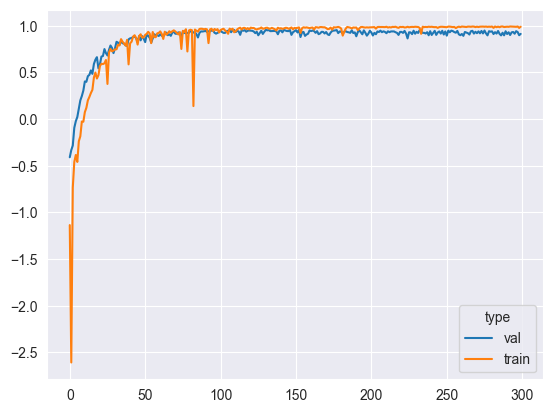

loss: tensor(111.9436, grad_fn=<AddBackward0>) 0.015805959701538086


In [232]:
loss, score = train(model, optim, loss_fn, 300, train_loader, val_loader)

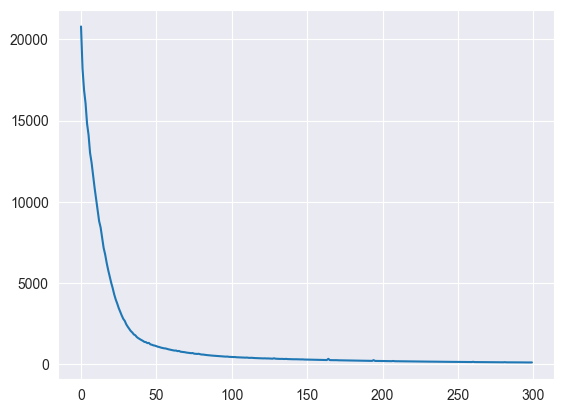

In [233]:
plt.plot(loss);

In [234]:
X_test = torch.tensor(X.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y.to_numpy(), dtype=torch.float32)
test_loader = DataLoader(list(zip(X_test, y_test)))

predictions = predict(model, test_loader)
predictions = list(map(lambda x: x.detach().numpy(), predictions))

In [235]:
predictions = list(map(lambda x: x.reshape(-1).tolist(), predictions))

In [236]:
predictions = np.array(list(chain.from_iterable(predictions)))

In [237]:
predictions = convert(predictions)

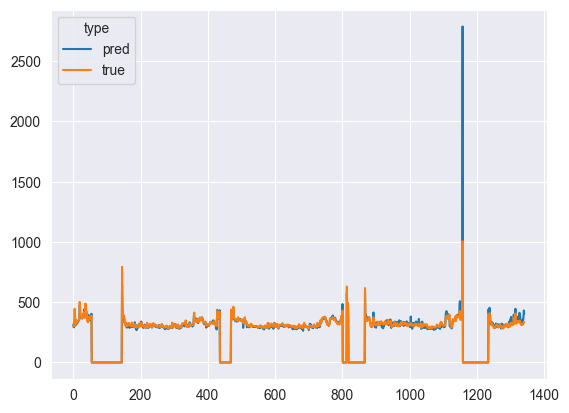

In [238]:
plt.plot(predictions, label="pred")
plt.plot(y.to_numpy(), label="true")
plt.legend(title="type");

In [239]:
r2_score(y.to_numpy(), predictions)

0.8570318577235009

In [240]:
len(data.drop(get_columns_without_tagrets(target), axis=1).columns)

36

In [292]:
X_new = np.array([[0] * 36])
y_new = np.array([[0] * 3])

In [293]:
for i in range(len(data.drop(get_columns_without_tagrets(target), axis=1).values) - 3):
    concat_x_data = data.drop(
        get_columns_without_tagrets(target), axis=1
    ).iloc[i].values
    concat_y_data = np.stack(
        [
            data.drop(
                get_columns_without_tagrets(target), axis=1
            ).iloc[i + 1][target],
            data.drop(
                get_columns_without_tagrets(target), axis=1
            ).iloc[i + 2][target],
            data.drop(
                get_columns_without_tagrets(target), axis=1
            ).iloc[i + 3][target]
        ]
    )

    X_new = np.append(X_new, [concat_x_data], axis=0)
    y_new = np.append(y_new, [concat_y_data], axis=0)

In [294]:
X_new = X_new[1:]
y_new = y_new[1:]

In [295]:
input_shape = X.shape[1]

In [407]:
class SimpleNN2(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleNN2, self).__init__()
        self.fc1 = nn.Linear(input_shape, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [408]:
X_train = torch.tensor(X_new[:900], dtype=torch.float32)
y_train = torch.tensor(y_new[:900], dtype=torch.float32)
X_val = torch.tensor(X_new[900:], dtype=torch.float32)
y_val = torch.tensor(y_new[900:], dtype=torch.float32)
train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=16)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle=True, batch_size=16)

In [409]:
model = SimpleNN2()
loss_fn = nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(), 1e-5)

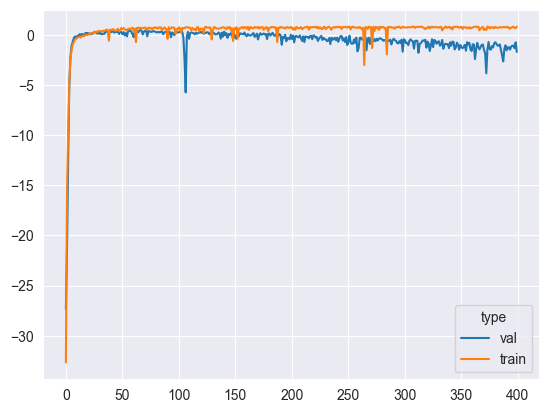

loss: tensor(2538.0452, grad_fn=<AddBackward0>) 0.03235793113708496


In [410]:
loss, score = train(model, optim, loss_fn, 400, train_loader, val_loader)

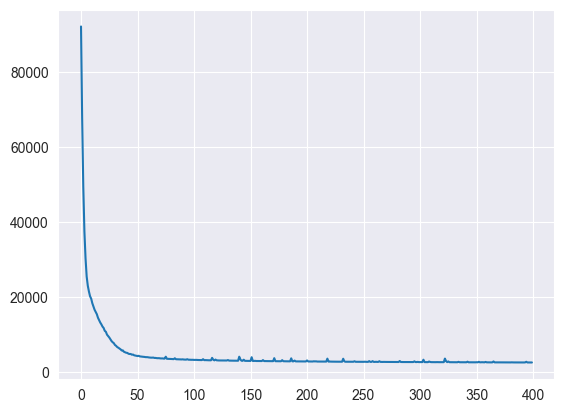

In [411]:
plt.plot(loss);

In [412]:
X_test = torch.tensor(X_new, dtype=torch.float32)
y_test = torch.tensor(y_new, dtype=torch.float32)
test_loader = DataLoader(list(zip(X_test, y_test)))

predictions = predict(model, test_loader)
predictions = list(map(lambda x: list(convert(x.detach().numpy()[0])), predictions))

In [413]:
# predictions = np.array(list(chain.from_iterable(predictions)))

In [414]:
difference = np.array([[0, 0, 0]])
for pred, real in zip(predictions, y_test):
    # print(f"difference: {real - torch.tensor(pred)}")
    difference = np.append(difference, [(real - torch.tensor(pred)).numpy()], axis=0)

In [415]:
difference = difference[1:]

In [416]:
difference[:20]

array([[-37.00942993, -18.03170776, -15.49310303],
       [-34.75820923, -32.56359863,  99.62109375],
       [-26.19955444, 107.94732666,  35.28106689],
       [ 70.77017212,  20.3576355 , -13.64642334],
       [ 13.46148682, -15.18017578, -23.88418579],
       [-28.89343262,  -3.25778198,   8.35900879],
       [ -8.75918579,  13.77648926,  31.67596436],
       [ 23.52438354,  43.94299316,  27.61465454],
       [ 13.01638794,   5.22113037,   6.11355591],
       [ -6.88925171,  -2.75500488,   9.16983032],
       [-10.80764771,  -3.32131958,  -2.65869141],
       [ -8.28204346,  -5.9710083 ,  -2.30438232],
       [ -9.59719849, -11.52987671,  -3.77108765],
       [ -8.53167725, -10.92572021,  -4.4624939 ],
       [ -5.12213135,  -7.29083252,  -2.35403442],
       [-13.63464355, -18.30322266,  -8.45700073],
       [-16.51202393, -12.70742798, 129.36557007],
       [ -9.64151001, 121.54431152,  82.32189941],
       [123.79159546,  77.62316895,  20.16854858],
       [ 21.16195679, -20.36987

In [417]:
r2_score(y_test, predictions)

0.6855159393236988